<a href="https://colab.research.google.com/github/obov/mnist/blob/main/1_3_MNIST.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MNIST 실습

이번에는 28x28 흑백 손글씨 이미지를 보고 0~9 사이의 숫자 중 어떤 숫자를 쓴 것인지 예측하는 문제를 실습합니다.
이번 실습에서는 GPU를 활용할 것이기 때문에, 이전 챕터에서 Colab에서 GPU를 설정하는 방법을 따라해주시길 바랍니다.

GPU를 설정했으면 library들을 import합니다.

In [1]:
'''
HYPER PARAMETERS
'''
LEARNING_RATE = 0.001
NUMBER_OF_EPOCHS = 50
BATCH_SIZE = 256
DATA_SET_NAME = 'CIFAR10'
ACTIVATION_FUNCTION = 'LeakyReLU'


In [2]:
import torch
import torchvision
import torchvision.transforms as transforms

다음은 dataset을 준비합니다. 손글씨 dataset은 MNIST라는 유명한 dataset이 있습니다. 이 dataset은 `torchvision`에서 제공하고 있으며, 다음과 같이 다운로드 받을 수 있습니다.

In [3]:
transform = transforms.ToTensor()

trainset = getattr(torchvision.datasets, DATA_SET_NAME)(
    root='./data',
    train=True,
    download=True,
    transform=transform
)

Files already downloaded and verified


MNIST는 손글씨 사진과 어떤 숫자를 의미하는지에 대한 label의 pair들로 구성되어있습니다.
이 때, 우리는 PyTorch model을 사용할 것이기 때문에 손글씨 사진들을 모두 tensor로 변환해야합니다.
이러한 부가적인 변환들은 `torchvision.transforms`에서 제공하고 있으며, `torchvision.datasets.MNIST`에서 `transform` 인자로 받을 수 있습니다.
우리는 단순히 사진을 tensor로 바꾸고 싶기 때문에 `transforms.ToTensor()` transformation을 넘겨줍니다.

다음은 전체 data의 개수와 첫 번째 data를 출력한 결과입니다.

50000
torch.Size([3, 32, 32]) 6


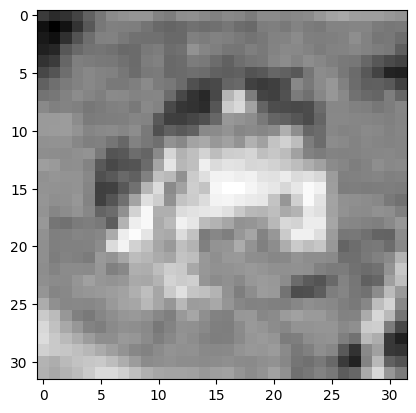

In [4]:
from matplotlib import pyplot as plt


print(len(trainset))
print(trainset[0][0].shape, trainset[0][1])
plt.imshow(trainset[0][0][0], cmap='gray')

첫 번째 출력결과를 통해 우리는 6만장의 손글씨 data가 있는 것을 알 수 있습니다.
그리고 두 번째 출력결과를 통해 첫 번째 data의 shape은 (1, 28, 28)이고 5라는 숫자를 쓴 사진이라는 것을 알 수 있습니다.
마지막으로 `plt.imshow`를 통해 visualize 했을 때 5라는 숫자가 나오는 것을 알 수 있습니다.

다음은 SGD를 위해 dataset을 여러 개의 batch로 나누는 과정을 PyTorch로 구현한 모습입니다.

In [5]:
from torch.utils.data import Subset


batch_size = BATCH_SIZE
# 0부터 47999까지는 훈련용, 48000부터 59999까지는 검증용으로 설정
train_indices = list(range(40000))
val_indices = list(range(40000, 50000))

train_dataset = Subset(trainset, train_indices)
val_dataset = Subset(trainset, val_indices)

train_loader = torch.utils.data.DataLoader(
    train_dataset, 
    batch_size=batch_size,
    shuffle=True
)
val_loader = torch.utils.data.DataLoader(
    val_dataset,
    batch_size=batch_size, 
    shuffle=False
)

PyTorch에서는 `DataLoader`가 dataset을 인자로 받아 batch로 나눠줍니다.
부가적으로 `batch_size`라는 인자를 통해 batch size를 받고 있으며, `shuffle`이라는 인자를 통해 data들을 섞을지 결정해줍니다.
우리는 SGD가 완전 랜덤으로 batch를 구성해야 잘 동작하는 것을 알고 있기 때문에 `shuffle`에 `True`를 넘겨주고 있습니다.

다음은 첫 번째 batch를 출력한 모습입니다.

In [6]:
dataiter = iter(train_loader)
images, labels = next(dataiter)
print(images.shape, labels.shape)

torch.Size([256, 3, 32, 32]) torch.Size([256])


`images`는 첫 번째 batch의 image들이고 `labels`는 첫 번째 batch의 label들입니다.
위에서 batch size를 64로 설정했기 때문에 총 64개의 image와 label들이 있어야 합니다.
실제 shape 출력 결과를 보면 그렇다는 것을 알 수 있습니다.

다음은 (n, 1, 28, 28) shape의 image를 입력받아 0~9 사이의 정수 하나를 출력하는 3-layer MLP를 구현합니다.

In [7]:
from torch import nn

output_dim = 10

class Model(nn.Module):
    def __init__(self, input_dim, n_dim, output_dim, activation_function='LeakyReLU', dropout_prob=0.0):
        super().__init__()
        
        # 레이어 정의
        self.layer1 = nn.Linear(input_dim, n_dim)
        self.layer2 = nn.Linear(n_dim, n_dim)
        self.layer3 = nn.Linear(n_dim, output_dim)

        # 활성화 함수 설정
        self.act = getattr(nn, activation_function)()
        
        # 드롭아웃 레이어 (dropout_prob이 0이면 드롭아웃이 적용되지 않음)
        self.dropout = nn.Dropout(dropout_prob)

    def forward(self, x):
        x = torch.flatten(x, start_dim=1)  # 입력을 1D 벡터로 Flatten
        
        # 레이어 1 -> 활성화 함수 -> 드롭아웃
        x = self.act(self.layer1(x))
        x = self.dropout(x)
        
        # 레이어 2 -> 활성화 함수 -> 드롭아웃
        x = self.act(self.layer2(x))
        x = self.dropout(x)
        
        # 마지막 레이어 (출력 레이어)
        x = self.layer3(x)  # 마지막 레이어에서는 활성화 함수 필요 없음
        return x
    
input_dim = 3 * 32 * 32  # 32x32 크기의 3채널(RGB) 이미지를 Flatten한 크기

device = torch.device("mps")

model_leaky_ReLU = Model(input_dim, 1024, output_dim).to(device) # plot1, plot2
model_sigmoid = Model(input_dim, 1024, output_dim, 'Sigmoid').to(device) # plot2
model_leaky_ReLU_dropout = Model(input_dim, 1024, output_dim, 'LeakyReLU', 0.1).to(device) # plot3

이전의 2-layer MLP와 유사한 형태임을 알 수 있습니다.
여기서 특이사항은 `forward`의 첫 번째 줄에 `torch.flatten`을 사용한다는 것입니다.
`Linear`는 이전에도 봤다시피 (n, d) 형태의 shape을 입력받습니다.
이미지는 (n, 1, 28, 28)이기 때문에 (n, 1 * 28 * 28)로 shape을 변환해야 선형 함수에 입력으로 주어줄 수 있게 됩니다.
이 역할을 수행하는 것이 바로 `torch.flatten`입니다.
우리는 첫 번째 shape인 n을 보존할 것이기 때문에 flatten할 차원은 `start_dim=1`로 넘겨주게 됩니다.

다음은 gradient descent를 수행해줄 optimizer를 구현하는 모습입니다.

In [8]:
from torch.optim import SGD,Adam

lr = LEARNING_RATE

optimizer_sgd = SGD(model_leaky_ReLU.parameters(), lr=lr) # plot1
optimizer_adam = Adam(model_leaky_ReLU.parameters(), lr=lr) # plot1, plot2
optimizer_adam_sigmoid = Adam(model_sigmoid.parameters(), lr=lr) # plot2
optimizer_dropout = Adam(model_leaky_ReLU_dropout.parameters(), lr=lr) # plot3


이전 코드와 거의 똑같습니다. 다른 점은 `model.to('cuda')` 코드를 통해 우리가 구현한 model을 GPU로 옮긴 것입니다.
MNIST 부터는 모델과 data가 커지면서 훨씬 많은 행렬 연산이 이루어지기 때문에 GPU를 활용하는 것이 빠릅니다.

다음은 model을 MNIST에 학습하는 코드입니다.

In [9]:
n_epochs = NUMBER_OF_EPOCHS

import matplotlib.pyplot as plt
CEL = nn.CrossEntropyLoss()
train_accuracies = []
val_accuracies = []

device='mps'

def train_and_validate(model, optimizer):
    CEL = nn.CrossEntropyLoss()
    train_accuracies = []
    val_accuracies = []

    def accuracy(model, dataloader):
        cnt = 0
        acc = 0
        for data in dataloader:
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            preds = model(inputs)
            preds = torch.argmax(preds, dim=-1)
            
            cnt += labels.shape[0]
            acc += (labels == preds).sum().item()

        return acc / cnt

    for epoch in range(n_epochs):
        model.train()  # 훈련 모드로 전환
        total_loss = 0.0
        
        # 훈련 루프
        for data in train_loader:
            model.zero_grad()
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)
            
            preds = model(inputs)
            loss = CEL(preds, labels)
            loss.backward()
            optimizer.step()
            
            total_loss += loss.item()

        # 훈련 정확도
        train_accuracy = accuracy(model, train_loader)
        train_accuracies.append(train_accuracy)
        print(f"Epoch {epoch:3d} | Training Loss: {total_loss:.4f} | Accuracy : {train_accuracy:.2%}")
        
        # 검증 루프
        model.eval()  # 검증 모드로 전환
        val_loss = 0.0
        with torch.no_grad():  # 검증할 때는 no_grad()를 사용하여 파라미터 업데이트를 하지 않음
            for data in val_loader:
                inputs, labels = data
                inputs, labels = inputs.to(device), labels.to(device)
                
                preds = model(inputs)
                loss = CEL(preds, labels)
                val_loss += loss.item()

        # 검증 정확도
        val_accuracy = accuracy(model, val_loader)
        val_accuracies.append(val_accuracy)
        print(f"Epoch {epoch:3d} | Validation Loss: {val_loss:.4f} | Accuracy : {val_accuracy:.2%}")
    
    return train_accuracies, val_accuracies

In [10]:
import numpy as np
def plot_acc(train_accs, test_accs, label1='train', label2='validate'):
  x = np.arange(len(train_accs))

  plt.plot(x, train_accs, label=label1)
  plt.plot(x, test_accs, label=label2)
  plt.legend()
  plt.show()

In [11]:
# PLOT1
sgd_train_accuracies, _ = train_and_validate(model_leaky_ReLU, optimizer_sgd)
adam_train_accuracies, _ = train_and_validate(model_leaky_ReLU, optimizer_adam)

Epoch   0 | Training Loss: 360.9733 | Accuracy : 12.12%
Epoch   0 | Validation Loss: 91.7794 | Accuracy : 12.43%
Epoch   1 | Training Loss: 359.5974 | Accuracy : 11.73%
Epoch   1 | Validation Loss: 91.4481 | Accuracy : 12.01%
Epoch   2 | Training Loss: 358.3523 | Accuracy : 12.34%
Epoch   2 | Validation Loss: 91.1369 | Accuracy : 12.74%
Epoch   3 | Training Loss: 357.1360 | Accuracy : 12.85%
Epoch   3 | Validation Loss: 90.8231 | Accuracy : 13.19%
Epoch   4 | Training Loss: 355.8923 | Accuracy : 14.29%
Epoch   4 | Validation Loss: 90.4987 | Accuracy : 14.69%
Epoch   5 | Training Loss: 354.6016 | Accuracy : 16.86%
Epoch   5 | Validation Loss: 90.1630 | Accuracy : 17.00%
Epoch   6 | Training Loss: 353.2459 | Accuracy : 18.81%
Epoch   6 | Validation Loss: 89.8083 | Accuracy : 18.65%
Epoch   7 | Training Loss: 351.7877 | Accuracy : 21.04%
Epoch   7 | Validation Loss: 89.4352 | Accuracy : 20.83%
Epoch   8 | Training Loss: 350.2544 | Accuracy : 22.50%
Epoch   8 | Validation Loss: 89.0405 | A

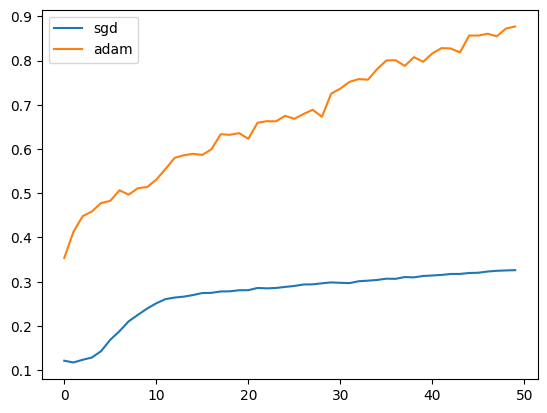

In [12]:
# PLOT1
plot_acc(sgd_train_accuracies,adam_train_accuracies,'sgd','adam')

In [13]:
# PLOT2
leaky_ReLU_train_accuracies, _ = train_and_validate(model_leaky_ReLU, optimizer_adam)
sigmoid_train_accuracies, _ = train_and_validate(model_sigmoid, optimizer_adam_sigmoid)

Epoch   0 | Training Loss: 59.1784 | Accuracy : 88.19%
Epoch   0 | Validation Loss: 92.9613 | Accuracy : 52.37%
Epoch   1 | Training Loss: 56.5554 | Accuracy : 85.88%
Epoch   1 | Validation Loss: 101.2891 | Accuracy : 50.51%
Epoch   2 | Training Loss: 51.7861 | Accuracy : 89.48%
Epoch   2 | Validation Loss: 97.5222 | Accuracy : 51.24%
Epoch   3 | Training Loss: 52.0079 | Accuracy : 89.76%
Epoch   3 | Validation Loss: 98.0090 | Accuracy : 52.02%
Epoch   4 | Training Loss: 48.5132 | Accuracy : 89.90%
Epoch   4 | Validation Loss: 102.0778 | Accuracy : 51.96%
Epoch   5 | Training Loss: 48.1573 | Accuracy : 90.41%
Epoch   5 | Validation Loss: 103.2126 | Accuracy : 51.50%
Epoch   6 | Training Loss: 48.7224 | Accuracy : 89.49%
Epoch   6 | Validation Loss: 103.0099 | Accuracy : 51.54%
Epoch   7 | Training Loss: 41.5268 | Accuracy : 91.95%
Epoch   7 | Validation Loss: 104.6484 | Accuracy : 52.50%
Epoch   8 | Training Loss: 41.2910 | Accuracy : 91.01%
Epoch   8 | Validation Loss: 109.3677 | Accu

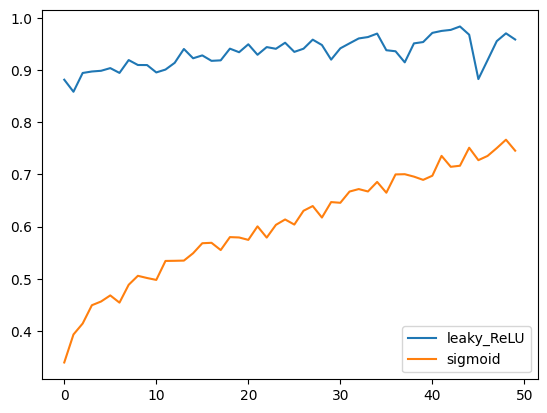

In [14]:
# PLOT2
plot_acc(leaky_ReLU_train_accuracies,sigmoid_train_accuracies,'leaky_ReLU','sigmoid')

In [15]:
# PLOT3
dropout_train_accuracies,dropout_validate_accuracies = train_and_validate(model_leaky_ReLU_dropout, optimizer_dropout)

Epoch   0 | Training Loss: 302.0485 | Accuracy : 34.80%
Epoch   0 | Validation Loss: 72.2186 | Accuracy : 34.29%
Epoch   1 | Training Loss: 268.0507 | Accuracy : 39.69%
Epoch   1 | Validation Loss: 69.0974 | Accuracy : 39.04%
Epoch   2 | Training Loss: 256.6968 | Accuracy : 42.97%
Epoch   2 | Validation Loss: 64.7300 | Accuracy : 42.65%
Epoch   3 | Training Loss: 245.8957 | Accuracy : 41.74%
Epoch   3 | Validation Loss: 66.0438 | Accuracy : 41.21%
Epoch   4 | Training Loss: 241.0470 | Accuracy : 45.11%
Epoch   4 | Validation Loss: 62.9415 | Accuracy : 44.22%
Epoch   5 | Training Loss: 235.9455 | Accuracy : 45.37%
Epoch   5 | Validation Loss: 62.9243 | Accuracy : 44.15%
Epoch   6 | Training Loss: 231.7098 | Accuracy : 49.36%
Epoch   6 | Validation Loss: 59.6147 | Accuracy : 47.67%
Epoch   7 | Training Loss: 227.2476 | Accuracy : 47.55%
Epoch   7 | Validation Loss: 61.4049 | Accuracy : 45.49%
Epoch   8 | Training Loss: 224.0357 | Accuracy : 46.88%
Epoch   8 | Validation Loss: 63.0784 | A

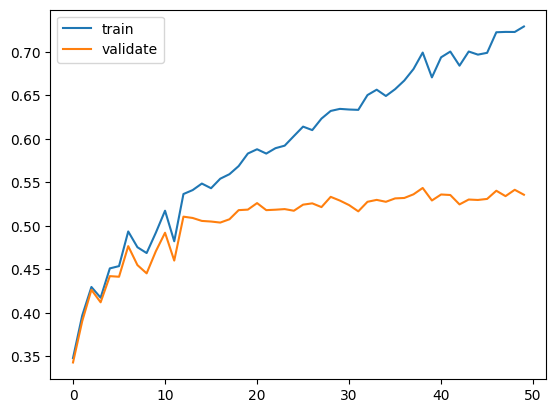

In [16]:
# PLOT3
plot_acc(dropout_train_accuracies,dropout_validate_accuracies,'train','validate ')